In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

from run_utils import run_env_experiment, plot_ratings_mses

sys.path.append('../') 
from reclab.environments import Topics
from reclab.environments import Engelhardt
from reclab.environments import LatentFactorBehavior
from reclab.recommenders import LibFM
from reclab.recommenders import KNNRecommender
from reclab.recommenders import TopPop
from reclab.recommenders import Autorec
from reclab.recommenders import Llorma



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Illustration of Different User Behaviors

In this notebook, for a fixed level of model and user behavior complexity, we illustrate the effect of different time-varying user behaviors on recommendation system quality. 
Specifically, we evaluate two metrics: observed ratings of recommended items, and predictive accuracy on recommended items. We may also want to look at diversity metrics, or those used in other papers.

In [14]:
## Key Parameters across all settings
expdirname = 'dynamic_user_static_rec'

topics = True

num_users = 100
num_items = 170
env_params = {
    'num_users': num_users,
    'num_items': num_items,
    'rating_frequency': 0.2,
    'num_init_ratings': 1000
}

exp_params = {
    'n_trials': 10,
    'len_trial': 20,
    'SEED': 24532,
}
num_init_ratings = 1000

## Static User Behavior

Here, the user model does not change over time. 

In [35]:
if topics:
    params = {'num_topics': 10}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'static_2'+env.name+'.npz'

recommenders = [
    LibFM(
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        max_num_users=num_users,
        max_num_items=num_items,
        method='sgd',
        learning_rate=0.01
    ),
    LibFM(
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        max_num_users=num_users,
        max_num_items=num_items,
        method='sgd',
        learning_rate=0.1
    ),
    Autorec(
        num_users=num_users,
        num_items=num_items,
        hidden_neuron=500,
        base_lr=1e-2,
        train_epoch=50
    ),
]
[
    KNNRecommender(
        user_based=True
    ),
    KNNRecommender(
        user_based=False
    ),
] 

ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, 1, 200, 
                                                                expdirname, datafilename, overwrite=True)

Started experiments on environment: topics
Running trials for recommender: libfm
Running trial: 0


/Users/karlk/repos/recsys-eval/experiments/run_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm



Running trials for recommender: libfm
Running trial: 0



Running trials for recommender: autorec
Running trial: 0


../reclab/recommenders/autorec/autorec_lib/autorec.py:135: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.array((Estimated_R[idx]))



Saving to data/dynamic_user_static_rec/static_2topics.npz


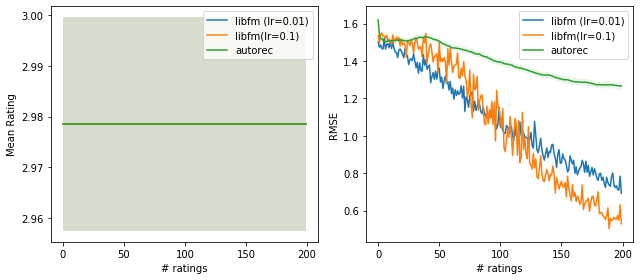

In [36]:
plot_ratings_mses(dense_ratings[0], dense_preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## Partially Hidden User Behavior

Here, there is a portion of item utility that is unknown to a user until the item is consumed. From the paper "How Algorithmic Confounding in Recommendation Systems
Increases Homogeneity and Decreases Utility".

In [ ]:
if topics:
    params = {'num_topics': 10}
    env = Engelhardt(**params, **env_params)

    datafilename = env.name+'.npz'
    ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, 1, 200, 
                                                                    expdirname, datafilename, overwrite=True)

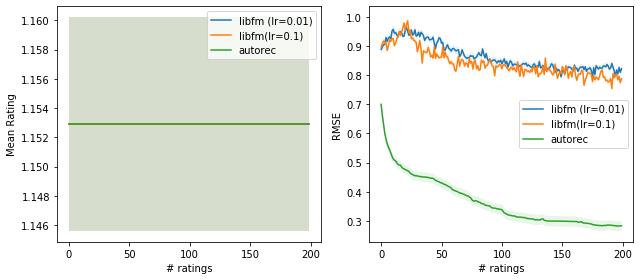

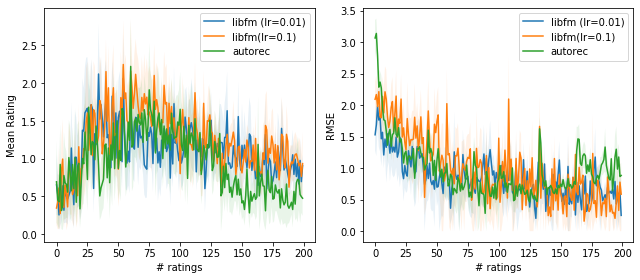

In [24]:
plot_ratings_mses(dense_ratings[0], dense_preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])
plot_ratings_mses(ratings[0], preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])


## User Interests Shift with Exposure

Here, the underlying user interest changes over time to match the body of items that have been recommended.

In [ ]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'increasing_interest_'+env.name+'.npz'
ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, 1, 200, 
                                                                expdirname, datafilename, overwrite=True)

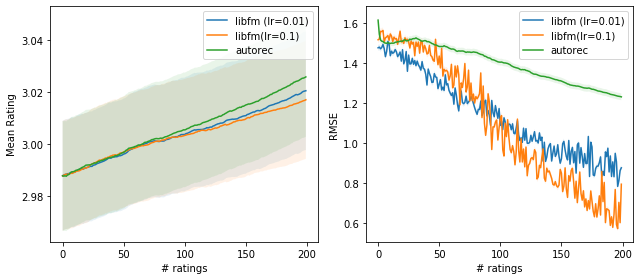

In [27]:
plot_ratings_mses(dense_ratings[0], dense_preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## User Gets Bored

Here, user interest decreases for items too similar to those that they have recently been exposed to, with some decay in the effect.

In [ ]:
if topics:
    params = {'num_topics': 10, 'memory_length': 5, 'boredom_threshold': 2, 
              'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'memory_length': 5, 'boredom_threshold': 0.5, 
              'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_'+env.name+'.npz'
ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, 1, 200, 
                                                                expdirname, datafilename, overwrite=True)

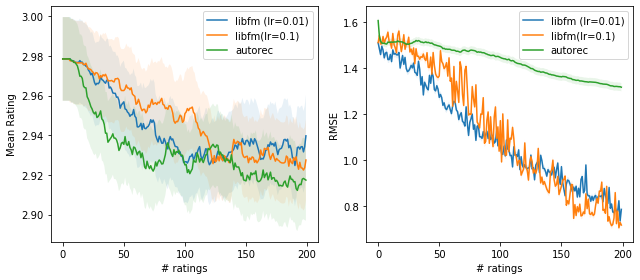

In [30]:
plot_ratings_mses(dense_ratings[0], dense_preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## User Interests Shift, also Gets Bored

This is a combination of the previous two cases, where users gradually become more interested in topics that they are exposed to, but also exhibit boredom when they see many similar items in a row.

In [ ]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 2, 'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 0.5, 'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_and_interest_'+env.name+'.npz'
ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, 10, 200, 
                                                                expdirname, datafilename, overwrite=True)

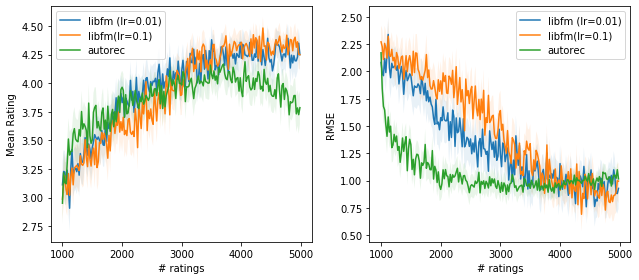

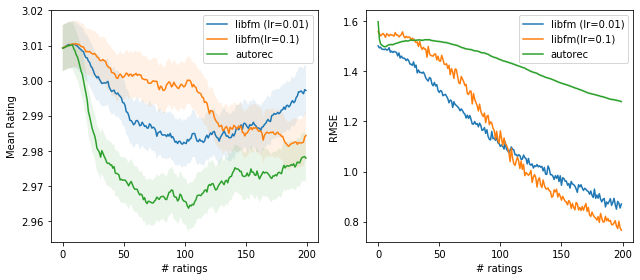

In [33]:
plot_ratings_mses(ratings[0], preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'],  num_init_ratings)
plot_ratings_mses(dense_ratings[0], dense_preds[0], ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])